## Pre-processing for Task

In [1]:
from monai import transforms as T
from monai.data import Dataset
from glob import glob
import os
import numpy as np
import torch
import matplotlib.pyplot as plt
from einops import rearrange

image_files = sorted(
    glob(
        os.path.join(
            "/cluster/projects/vc/data/mic/open/Prostate/PI-CAI/preped-images/images/",
            "imagesTr",
            "*.nii.gz",
        )
    )
)
label_files = sorted(
    glob(
        os.path.join(
            "/cluster/projects/vc/data/mic/open/Prostate/PI-CAI/preped-images/images/",
            "labelsTr",
            "*.nii.gz",
        )
    )
)

/cluster/home/eriksalv/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [1]:
from data_modules.pi_cai import PICAIDataModule

/cluster/home/eriksalv/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data = PICAIDataModule(batch_size=2, val_frac=0.2, train_frac=0.7, test_frac=0.1)
data.prepare_data()
data.setup()

Num AI labels: 188
Num Human expert labels: 220


In [ ]:
from data_modules.util.slice_inference import ConcatAdjacentSlicesToChannelsd

In [15]:
import torch.nn.functional as F

In [3]:
img = data.val_set[0]["image"]

torch.Size([3, 384, 384, 24])


In [4]:
img.shape

torch.Size([9, 384, 384, 24])

In [28]:
padded = F.pad(img, (1, 1))

In [15]:
import torch

In [16]:
result = torch.zeros((3 + 2*1*3, 384, 384, 24), dtype=img.dtype, device=img.device)

In [17]:
result.shape

torch.Size([9, 384, 384, 24])

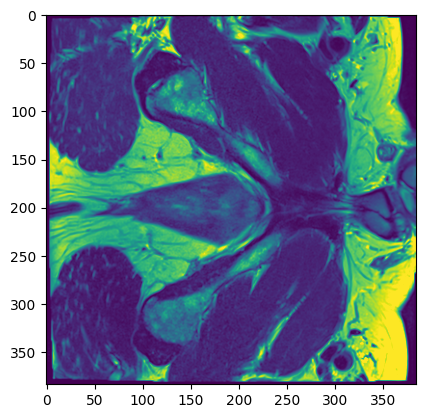

In [77]:
plt.imshow(rearrange(padded[:, :, :, 1:4], "c h w d -> (c d) h w")[0])

In [18]:
for i in range(1, 25):
    result[:, :, :, i-1] = rearrange(padded[:, :, :, i-1:i+2], "c h w d -> (c d) h w")

NameError: name 'rearrange' is not defined

In [6]:
import matplotlib.pyplot as plt

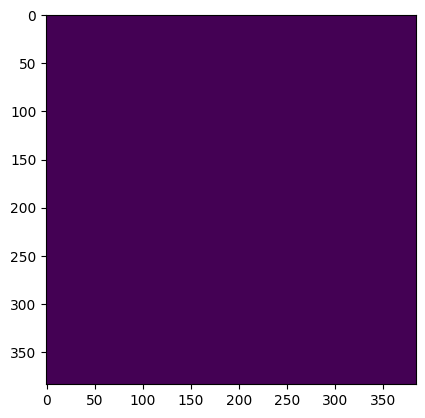

In [13]:
plt.imshow(img[7, :, :, 23])

In [8]:
ConcatAdjacentSlicesToChannelsd(keys="image", n_adjacent_slices=1)(data.val_set[0])

torch.Size([3, 384, 384, 24])


{'image': metatensor([[[[-1.2674e+00, -1.2674e+00, -1.2674e+00,  ..., -1.2674e+00,
            -1.2674e+00, -1.2674e+00],
           [-1.2674e+00, -1.2674e+00, -1.2674e+00,  ..., -1.2674e+00,
            -1.2674e+00, -1.2674e+00],
           [-1.2674e+00, -1.2674e+00, -1.2674e+00,  ..., -1.2674e+00,
            -1.2674e+00, -1.2674e+00],
           ...,
           [-1.2674e+00, -1.2674e+00, -1.2674e+00,  ..., -1.2674e+00,
            -1.2644e+00, -1.2615e+00],
           [-1.2674e+00, -1.2674e+00, -1.2674e+00,  ..., -1.2674e+00,
            -1.2630e+00, -1.2585e+00],
           [-1.2674e+00, -1.2674e+00, -1.2674e+00,  ..., -1.2674e+00,
            -1.2644e+00, -1.2615e+00]],
 
          [[-1.2674e+00, -1.2674e+00, -1.2674e+00,  ..., -1.2674e+00,
            -1.2674e+00, -1.2674e+00],
           [-1.2674e+00, -1.2674e+00, -1.2674e+00,  ..., -1.2674e+00,
            -1.2674e+00, -1.2674e+00],
           [-1.2674e+00, -1.2674e+00, -1.2674e+00,  ..., -1.2674e+00,
            -1.2674e+00, -

In [2]:
class ConvertToMultiChanneld(T.MapTransform):
    def __call__(self, data):
        d = dict(data)
        for key in self.keys:
            if key in data:
                label = d[key]  # Extract label tensor

                # Create a one-hot encoding with 3 channels (excluding background)
                result = [
                    (label == 1).float(),  # Class 1
                    (label == 2).float(),  # Class 2
                    (label == 3).float(),  # Class 3
                    (label == 4).float(),  # Class 4
                    (label == 5).float(),  # Class 5
                ]

                d[key] = torch.stack(
                    result, axis=0
                ).squeeze()  # Stack along channel axis
        return d


class ConvertToBinaryLabeld(T.MapTransform):
    def __call__(self, data):
        d = dict(data)
        for key in self.keys:
            if key in data:
                label = d[key]  # Extract label tensor

                # Convert to binary: 0 for ISUP ≤1, 1 for ISUP ≥2
                d[key] = (label >= 2).float()

        return d

In [3]:
default_preprocess = T.Compose(
    [
        T.LoadImaged(keys=["image", "label"]),
        T.EnsureChannelFirstd(keys=["image", "label"]),
        T.Orientationd(keys=["image", "label"], axcodes="RAS"),
        T.Spacingd(
            keys=["image", "label"],
            pixdim=(0.5, 0.5, 3),
            mode=("bilinear", "nearest"),
        ),
        T.CropForegroundd(
            keys=["image", "label"],
            source_key="image",
            channel_indices=0,
            allow_smaller=False,
        ),
        T.CenterSpatialCropd(keys=["image", "label"], roi_size=[384, 384, 24]),
        T.Resized(
            keys=["image", "label"],
            spatial_size=[384, 384, 24],
            mode=("area", "nearest"),
        ),
        T.ClipIntensityPercentilesd(keys="image", lower=None, upper=99, channel_wise=True),
        T.NormalizeIntensityd(keys="image", channel_wise=True),
        ConvertToBinaryLabeld(keys="label")
    ]
)

In [4]:
num_samples = 1
augment_spatial = T.Compose(
    [
        T.RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=0),
        T.RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=1),
        T.RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=2),
        T.Rand3DElasticd(
            keys=["image", "label"],
            prob=0.6,
            magnitude_range=(50, 80),
            sigma_range=(5, 7),
            mode=("bilinear", "nearest"),
        ),
        T.RandRotate90d(
            keys=["image", "label"], prob=0.5, max_k=3, spatial_axes=(0, 1)
        ),
        T.RandRotated(
            keys=["image", "label"],
            prob=0.4,
            range_x=[-0.25, 0.25],
            range_y=[-0.25, 0.25],
            range_z=[-0.25, 0.25],
            mode=("bilinear", "nearest"),
            padding_mode="border",
        ),
    ]
)

augment_intensity = T.Compose(
    [
        T.RandGaussianNoised(keys="image", prob=0.3, std=0.1),
        T.RandAdjustContrastd(
            keys="image", prob=0.4, gamma=[0.7, 1.5], retain_stats=True,
        ),
        T.RandScaleIntensityd(keys="image", prob=0.6, factors=0.1, channel_wise=True),
        T.RandShiftIntensityd(keys="image", prob=0.5, offsets=0.1, channel_wise=True)
    ]
)

In [5]:
transform = T.Compose([default_preprocess, augment])

In [4]:
data = [{"image": img, "label": lbl} for img, lbl in zip(image_files, label_files)]

dataset = Dataset(
    data,
    transform=default_preprocess,
)


In [6]:
from monai.transforms import SaveImage

In [9]:
save = SaveImage(output_dir="./data/test/", output_postfix='pred', separate_folder=False)
save(dataset[0]["image"])

2025-02-23 20:16:59,020 INFO image_writer.py:197 - writing: data/test/10005_1000005_pred.nii.gz


metatensor([[[[-1.3480, -1.3480, -1.3480,  ..., -1.3480, -1.3480, -1.3480],
          [-1.3480, -1.3480, -1.3480,  ..., -1.3460, -1.3440, -1.3440],
          [-1.3480, -1.3480, -1.3480,  ..., -1.3380, -1.3340, -1.3400],
          ...,
          [-1.3480, -1.3480, -1.3480,  ..., -1.3480, -1.3480, -1.3480],
          [-1.3199, -1.3239, -1.3279,  ..., -1.3480, -1.3480, -1.3480],
          [-1.2918, -1.2999, -1.3079,  ..., -1.3480, -1.3480, -1.3480]],

         [[-1.3480, -1.3480, -1.3480,  ..., -1.3480, -1.3480, -1.3480],
          [-1.3480, -1.3480, -1.3480,  ..., -1.3460, -1.3450, -1.3460],
          [-1.3480, -1.3480, -1.3480,  ..., -1.3380, -1.3360, -1.3400],
          ...,
          [-1.3480, -1.3480, -1.3480,  ..., -1.3289, -1.3249, -1.3320],
          [-1.3340, -1.3360, -1.3380,  ..., -1.3289, -1.3249, -1.3320],
          [-1.3199, -1.3239, -1.3279,  ..., -1.3480, -1.3480, -1.3480]],

         [[-1.3480, -1.3480, -1.3480,  ..., -1.3480, -1.3480, -1.3480],
          [-1.3480, -1.348

In [10]:
import nibabel as nib

In [12]:
image = nib.load('/cluster/projects/vc/data/mic/open/Prostate/PI-CAI/preped-images/images/imagesTr/10005_1000005.nii.gz').get_fdata()
gt = nib.load('/cluster/projects/vc/data/mic/open/Prostate/PI-CAI/preped-images/images/labelsTr/10005_1000005.nii.gz').get_fdata()
pred = nib.load('./data/picai/pred/10005_1000005_pred.nii.gz').get_fdata()

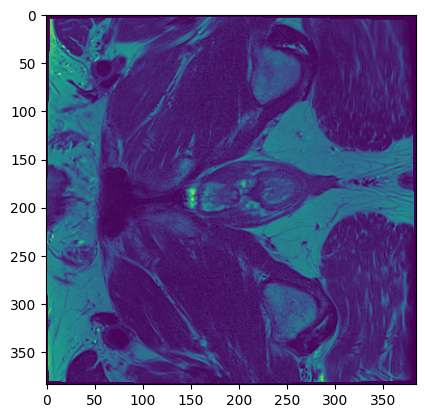

In [17]:
plt.imshow(image[:, :, 0, 0])

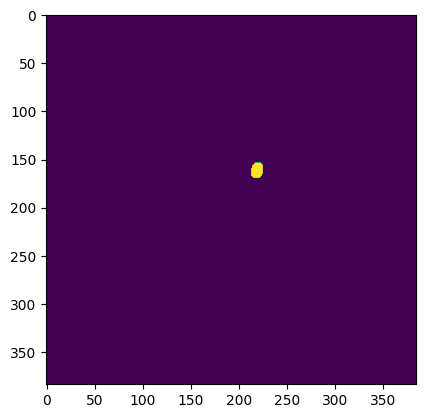

In [22]:
plt.imshow(gt[:, :, 9])

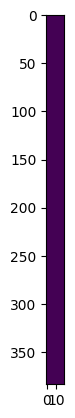

In [26]:
plt.imshow(pred[:, 192, :])

In [45]:
from tqdm import tqdm

In [191]:
pixdims = []
shapes = []
labels = []

for sample in tqdm(dataset):
    image, label = sample["image"], sample["label"]
    pixdims.append(image.pixdim)
    shapes.append(image.shape)
    labels.append(torch.unique(label, return_counts=True))

100%|██████████| 408/408 [13:47<00:00,  2.03s/it]


In [432]:
torch.quantile(dataset[0]["image"], 0)

metatensor(-1.3480)

In [202]:
count = 0
size = 0
for label in labels:
    if label[1].shape == torch.Size([2]):
        count += 1
        size += label[1][1].item()
print(count)
print(size / count)

220
4753.777272727273


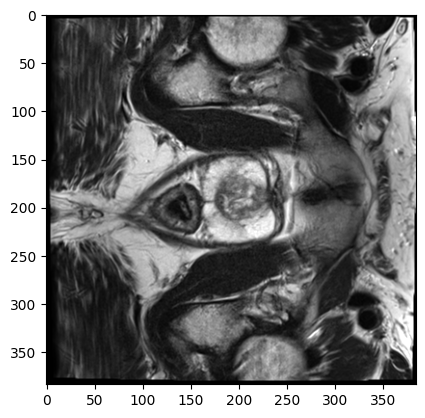

In [428]:
plt.imshow(dataset[0]["image"][0, :, :, 10], cmap="grey")

torch.Size([3, 384, 384, 24])


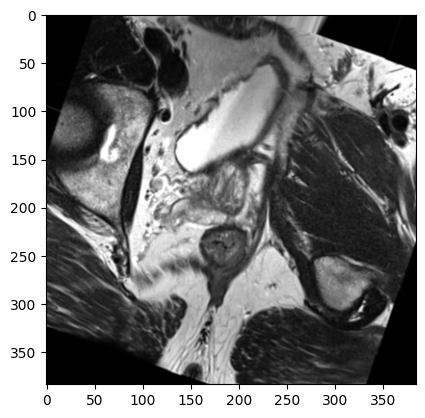

In [438]:
img = augment_intensity(augment_spatial(dataset[0]))['image']
print(img.shape)
plt.imshow(img[0, :, :, 10], cmap="grey")

In [7]:
loader = T.LoadImaged(keys=["image", "label"])
loaded_data = loader(data)

FileNotFoundError: [Errno 2] No such file or directory: 'label'

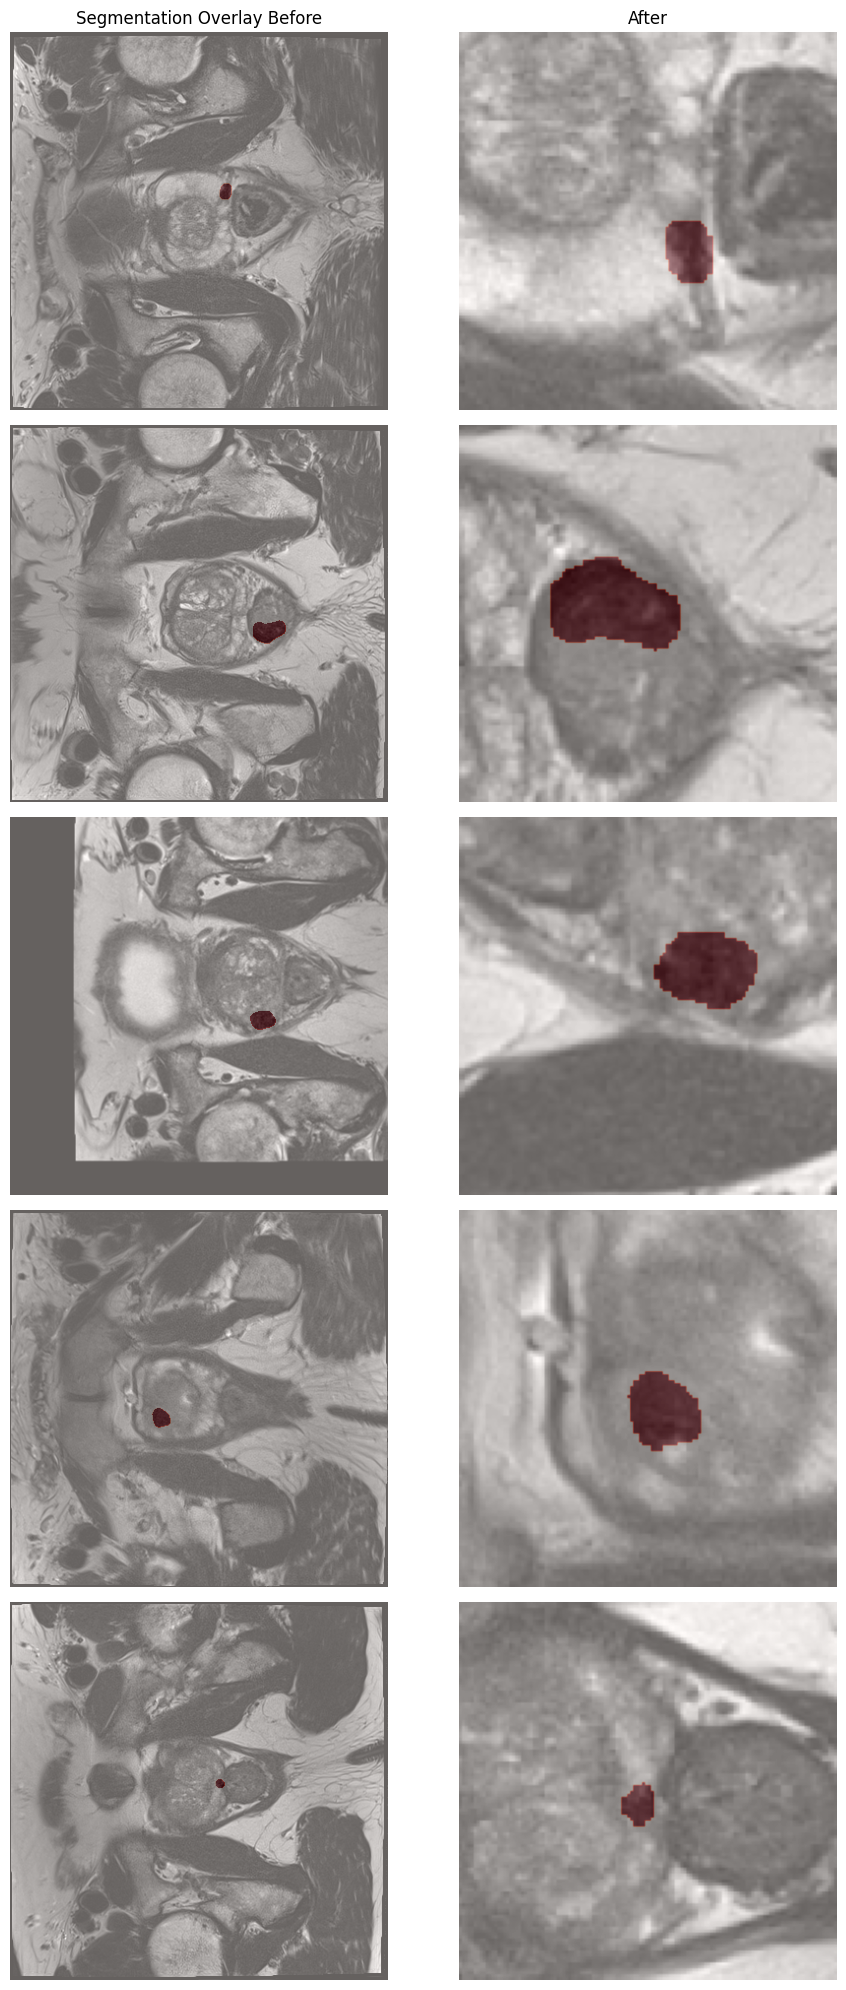

In [8]:
n = 5

fig, axes = plt.subplots(n, num_samples + 1, figsize=(10, 20))

axes[0, 0].set_title("Segmentation Overlay Before")
axes[0, 1].set_title("After")

for i in range(n):
    sample = loaded_data[i]
    label_slices = np.sum(sample["label"], axis=(0, 1))
    slice = np.argmax(label_slices)

    axes[i, 0].imshow(sample["image"][:, :, slice, 0], cmap="gray")
    axes[i, 0].imshow(sample["label"][:, :, slice], cmap="Reds", alpha=0.4)
    axes[i, 0].axis("off")

    for j in range(num_samples):  # Loop over augmented versions
        label_slices_final = np.sum(final_data[i][j]["label"][0], axis=(0, 1))
        slice_final = np.argmax(label_slices_final)

        axes[i, j + 1].imshow(
            final_data[i][j]["image"][0, :, :, slice_final], cmap="gray"
        )
        axes[i, j + 1].imshow(
            final_data[i][j]["label"][0, :, :, slice_final], cmap="Reds", alpha=0.4
        )
        axes[i, j + 1].axis("off")


plt.tight_layout()
plt.show()

In [9]:
final_data
unique_labels = set()
for s in final_data:
    label = s[0]["label"]  # Extract label tensor
    unique_values = torch.unique(label)  # Find unique values
    unique_labels.update(unique_values.tolist())  # Store them in a set

print(f"Unique label values across dataset: {sorted(unique_labels)}")
print(f"Number of unique classes: {len(unique_labels)}")

Unique label values across dataset: [0.0, 1.0]
Number of unique classes: 2


### Checking labels

In [10]:
import torch

data = [
    {"image": img, "label": lbl} for img, lbl in zip(image_files[:50], label_files[:50])
]
loaded_data = [loader(d) for d in data]

unique_labels = set()
for s in loaded_data:
    label = s["label"]  # Extract label tensor
    unique_values = torch.unique(label)  # Find unique values
    unique_labels.update(unique_values.tolist())  # Store them in a set

print(f"Unique label values across dataset: {sorted(unique_labels)}")
print(f"Number of unique classes: {len(unique_labels)}")


Unique label values across dataset: [0.0, 1.0, 2.0, 3.0, 4.0, 5.0]
Number of unique classes: 6
